## POSTPROECESSING

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import neptune
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_label_contours
from MODULES.utilities_visualization import plot_segmentation, movie_from_resolution_sweep
from MODULES.graph_clustering import GraphSegmentation
from MODULES.utilities import QC_on_integer_mask, concordance_integer_masks, load_json_as_dict, load_obj
from MODULES.utilities_visualization import contours_from_labels, add_red_contours
import skimage.io
import skimage.morphology
from IPython.display import HTML
from matplotlib import animation

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

python_version() --->  3.7.7
torch.__version__ -->  1.5.0


### Read the tiling

In [ ]:
#tiling = load_obj("tiling_new.pt")
tiling = load_obj("tiling_large.pt")

In [21]:
tiling.integer_mask[0,0,2388:,1420:1720].shape

torch.Size([300, 300])

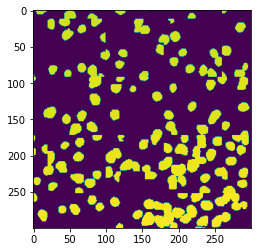

In [22]:
plt.imshow(tiling.integer_mask[0,0,2388:,1420:1720])

### Create graph

In [27]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
print(g.graph["total_nodes"])
print(g.graph["total_edge_weight"])
g.graph.summary()

Building the graph with python-igraph
756552
356716.625


'IGRAPH U-W- 756552 68389669 -- \n+ attr: total_edge_weight (g), total_nodes (g), label (v), weight (e)'

### Perform sweep on a small window

In [40]:
# sweep = numpy.arange(1.0, 20.0)
sweep = numpy.linspace(start=500, stop=1000, num=25)
print(sweep)
suggestion_mod_true = g.suggest_resolution_parameter(min_size=20,
                                                     window=window,
                                                     cpm_or_modularity="modularity",
                                                     each_cc_separately=False,
                                                     sweep_range=sweep)

[ 500.          520.83333333  541.66666667  562.5         583.33333333
  604.16666667  625.          645.83333333  666.66666667  687.5
  708.33333333  729.16666667  750.          770.83333333  791.66666667
  812.5         833.33333333  854.16666667  875.          895.83333333
  916.66666667  937.5         958.33333333  979.16666667 1000.        ]
tensor([ 0,  0,  0,  ..., 80, 80, 81], device='cuda:0')
resolution sweep,   0 out of  24
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resolution sweep,  10 out of  24
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
find partition internal
resolution sweep,  20 out of  24
find partition i

In [ ]:
#tiling = load_obj("tiling_new.pt")


### See the sweep

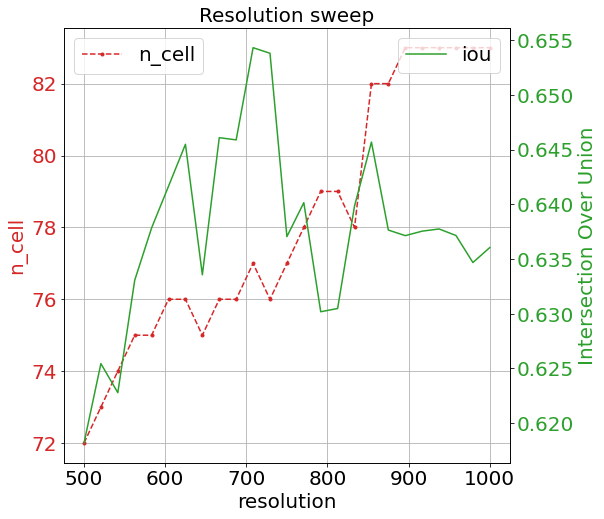

In [41]:
suggestion_mod_true.show_graph(figsize=(8,8))

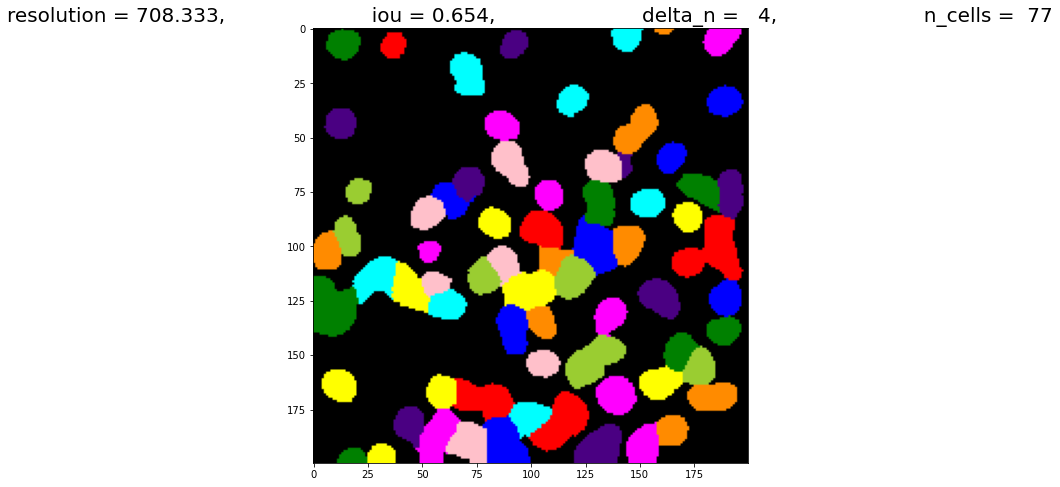

In [42]:
suggestion_mod_true.show_best(figsize=(8,8))

In [43]:
movie_from_resolution_sweep(suggestion_mod_true, tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]])

# Check tiling without graph

[2488, 1520, 2688, 1720]


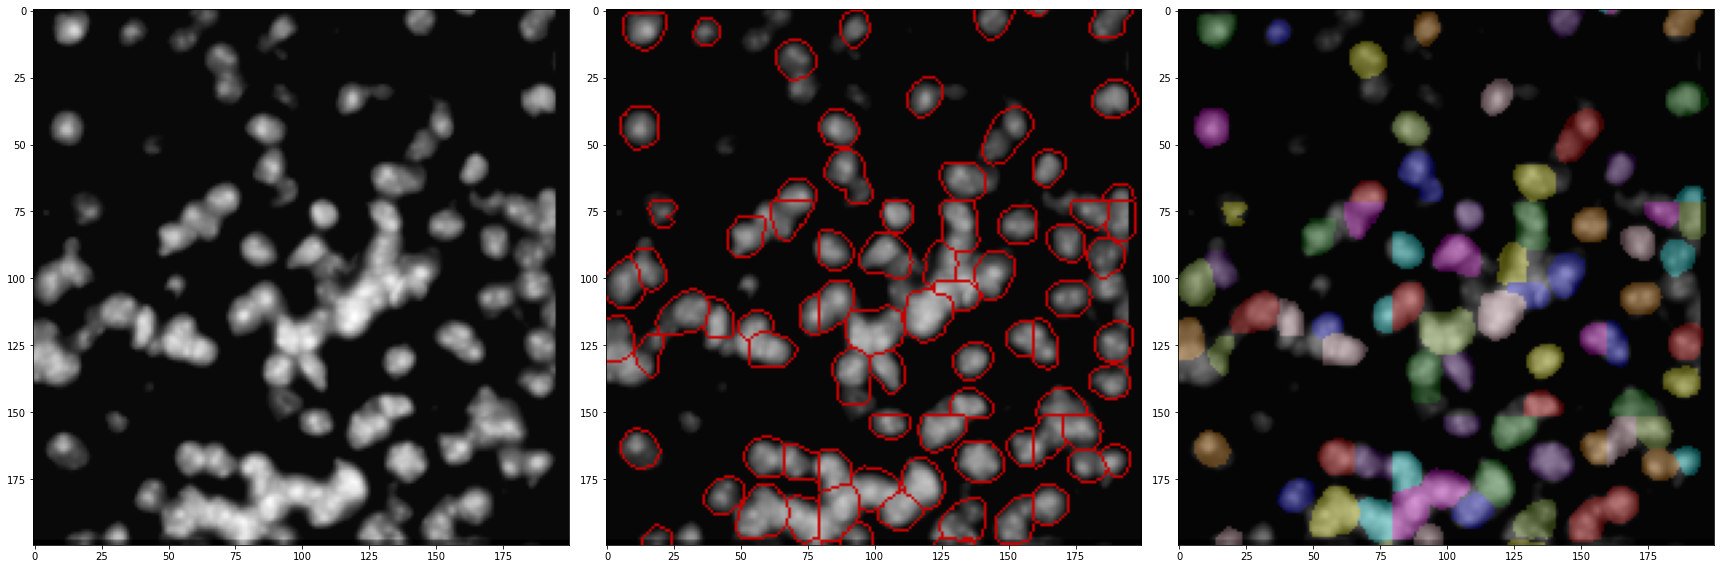

In [26]:
ix, iy, delta = 2488, 1520, 200
window = [ix, iy, ix+delta, iy+delta]

plot_label_contours(label=tiling.integer_mask[0,0],
                    image=tiling.raw_image[0],
                    window=window,
                    contour_thickness=1,
                    contour_color='red',
                    neptune_name=None) #"tiling_contours_graph")

# Segmentation with tiling

None


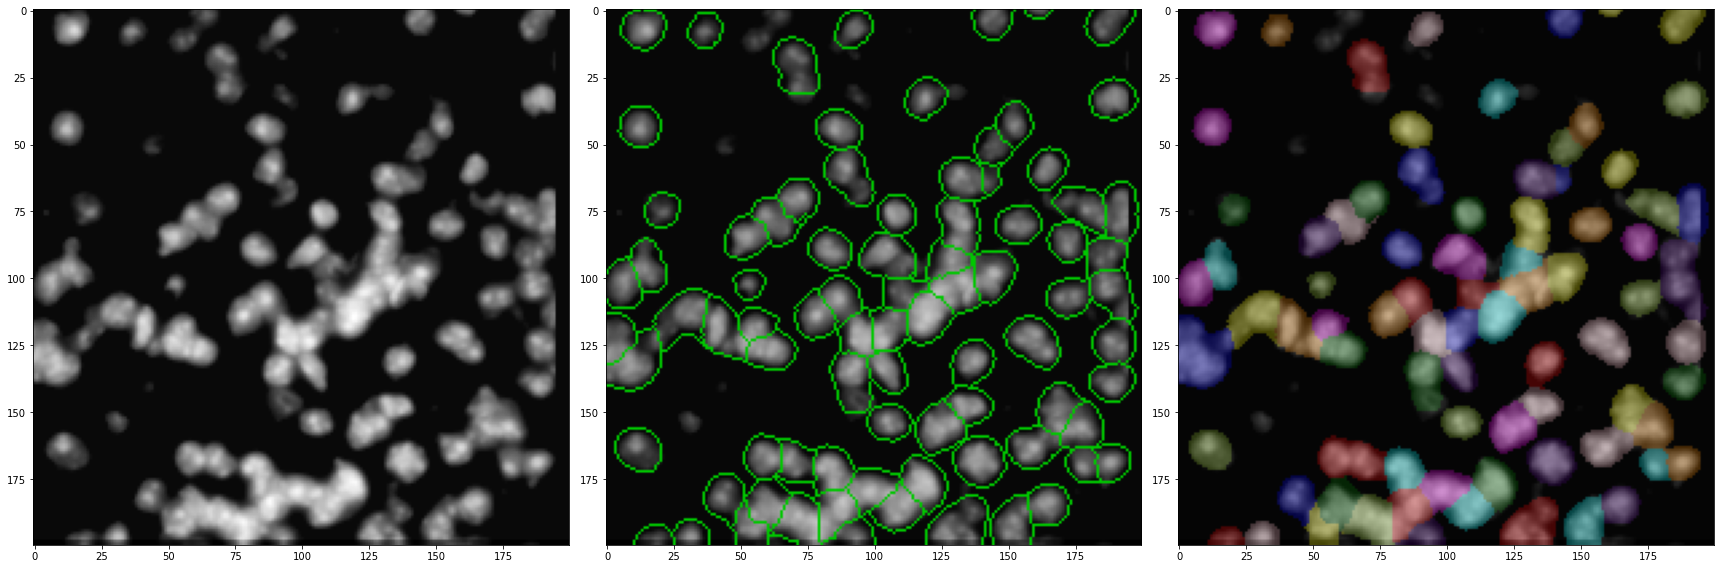

In [50]:
plot_label_contours(label=suggestion_mod_true.sweep_seg_mask[-1],
                    image=tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]],
                    window=None,
                    contour_thickness=1,
                    contour_color='green')

# FIGURE FOR PAPER

In [68]:

def draw_contours(image: numpy.ndarray, contours: numpy.ndarray, contours_color: str = 'red') -> numpy.ndarray:
    assert isinstance(image, numpy.ndarray)
    assert isinstance(contours, numpy.ndarray)
    assert contours.dtype == bool
    if (len(image.shape) == 3) and (image.shape[-1] == 3):
        image_with_contours = image
    elif len(image.shape) == 2:
        image_with_contours = skimage.color.gray2rgb(image)
    else:
        raise Exception
    if contours_color == 'red':
        ch_index = 0
    elif contours_color == 'green':
        ch_index = 1
    elif contours_color == 'blue':
        ch_index = 2
    else:
        raise Exception("contours_color not recognized. Should be 'red' or 'green' or 'blue'")

    image_with_contours[contours, :] = 0
    image_with_contours[contours, ch_index] = numpy.max(image_with_contours)
    return image_with_contours

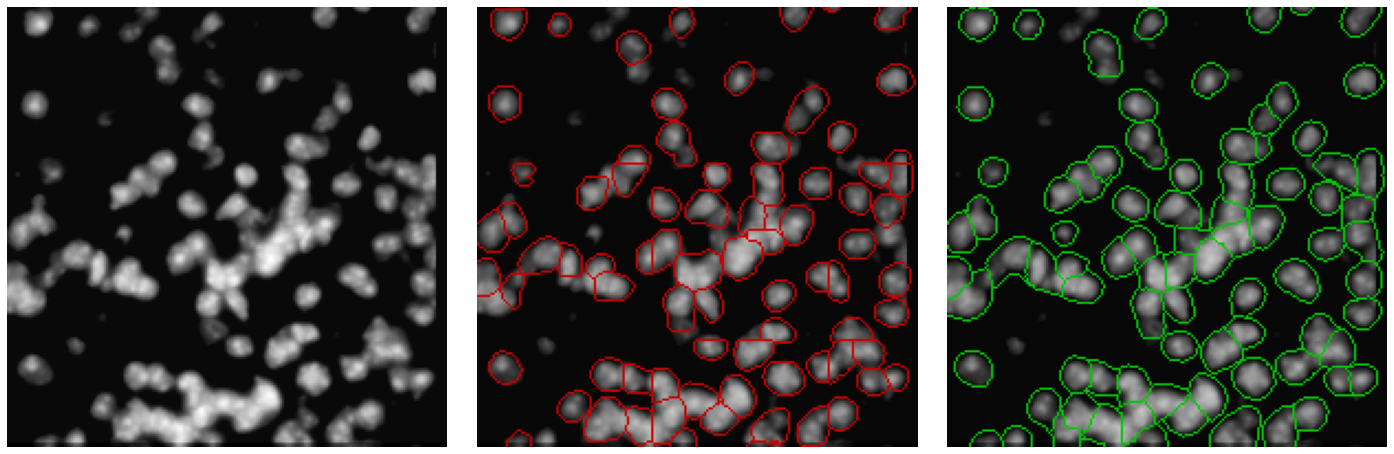

In [69]:
ix, iy, delta = 2488, 1520, 200
window = [ix, iy, ix+delta, iy+delta]
raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()

label_no_graph = tiling.integer_mask[0,0,window[0]:window[2], window[1]:window[3]].cpu().numpy()
c_no_graph = contours_from_labels(label_no_graph, contour_thickness=1)
seg_no_graph = draw_contours(image=raw_image, contours=c_no_graph, contours_color="red")

label_with_graph = suggestion_mod_true.sweep_seg_mask[-1].cpu().numpy()
c_with_graph = contours_from_labels(label_with_graph, contour_thickness=1)
seg_with_graph = draw_contours(image=raw_image, contours=c_with_graph, contours_color="green")

fig, ax = plt.subplots(ncols=3, figsize=(20,20))

ax[0].imshow(raw_image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(seg_no_graph)
ax[1].axis('off')
ax[2].imshow(seg_with_graph)
ax[2].axis('off')

fig.tight_layout(pad=3.0)
fig.savefig("./DAPI.pdf")
fig.savefig("./DAPI.png")

# Get Oleh results

In [55]:
oleh_file = "oleh_big.tif"
oleh_label = skimage.io.imread(oleh_file).astype(numpy.uint16)

raw_file = "smFISH_stitched_OLEH.tif"
raw_image = skimage.io.imread(raw_file).astype(numpy.uint16)

In [56]:
print(oleh_label.shape)
print(raw_image.shape)

(21505, 21505)
(21505, 21505)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19904, 12160, 21504, 13760]


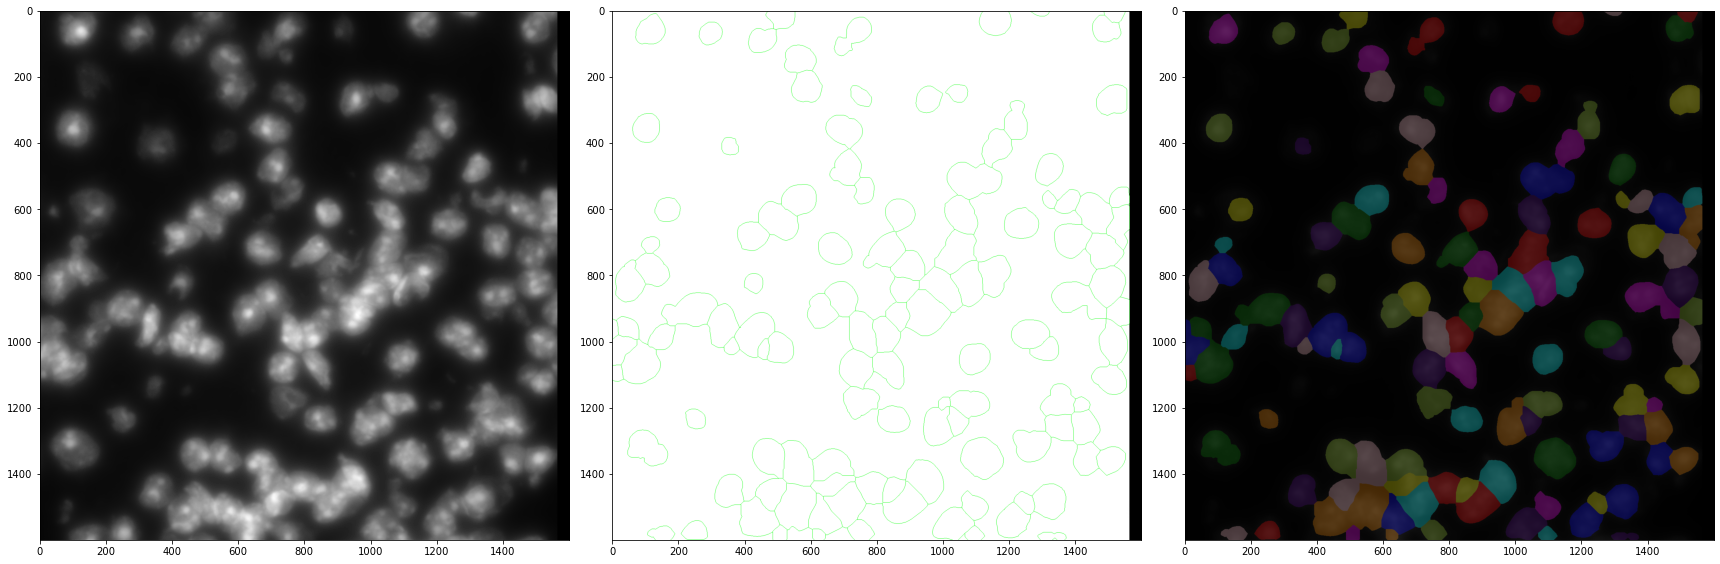

In [60]:
window_big =[ window[0]*8, window[1]*8, window[2]*8, window[3]*8 ] 
plot_label_contours(label=oleh_label,
                    image=raw_image,
                    window=window_big,
                    contour_thickness=1,
                    contour_color='green')

# Manual annotations 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19904, 12160, 21504, 13760]


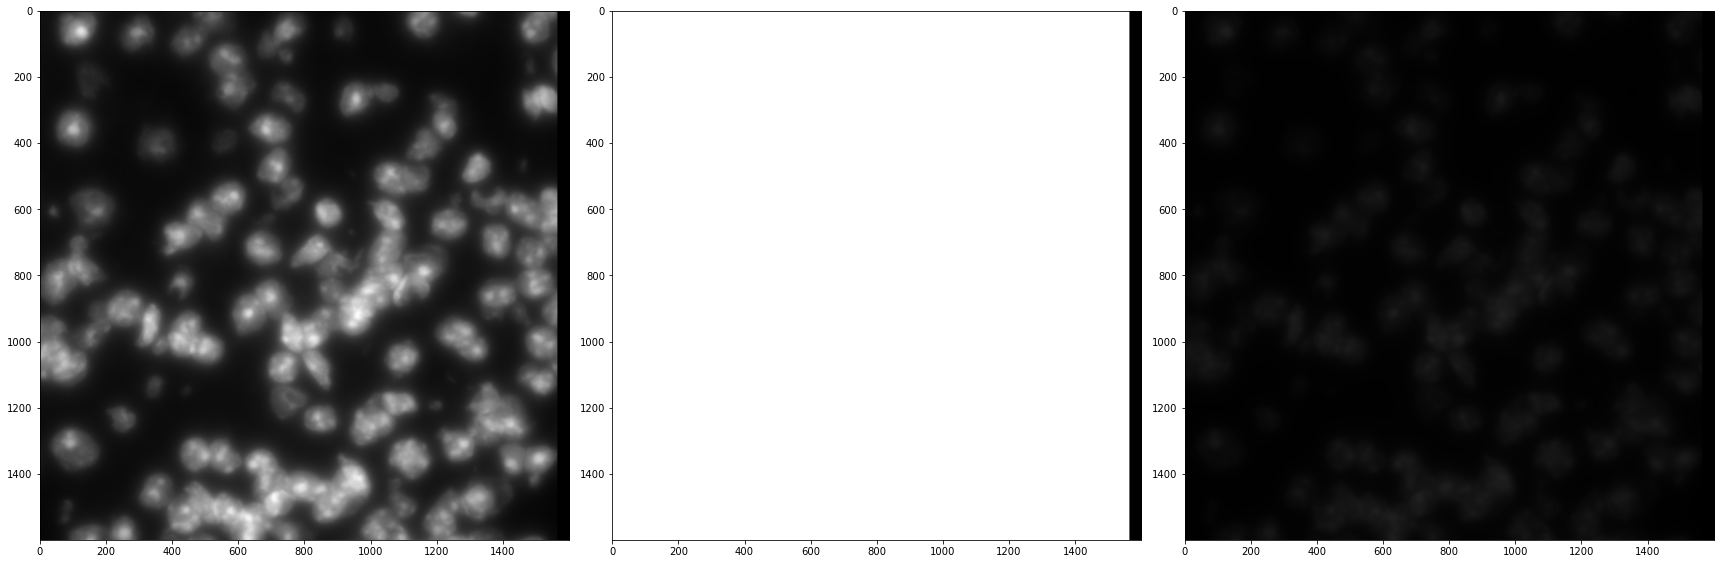

In [63]:
#gt_file = "manual_annotation_big.tif"
#gt_label = skimage.io.imread(gt_file).astype(numpy.uint16)

window_big =[ window[0]*8, window[1]*8, window[2]*8, window[3]*8 ] 
plot_label_contours(label=gt_label,
                    image=raw_image,
                    window=window_big,
                    contour_thickness=1,
                    contour_color='green')

In [ ]:
#suggestion_mod_true.sweep_seg_mask
suggestion_mod_true.

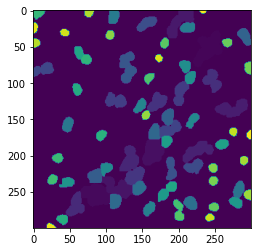

In [30]:
plt.imshow(suggestion_mod_true.sweep_seg_mask[0])

### Do community detection with the chiosen resolution parameter

In [ ]:
import time
start_time = time.time()
resolution = 400.0

partition = g.find_partition_leiden(resolution=resolution, 
                                    min_size=20, 
                                    cpm_or_modularity="modularity", 
                                    each_cc_separately=False,
                                    n_iterations=10,
                                    initial_membership=None) 
print("community detection time",time.time()-start_time)

### Vefiry results on the small window and check consistency

In [ ]:
graph_integer_mask = g.partition_2_integer_mask(partition)
save_obj(graph_integer_mask, "graph_integer_mask_large.pt")
skimage.io.imsave("luca_small.tif", graph_integer_mask.cpu().numpy(), plugin=None, check_contrast=True)

In [ ]:
plot_label_contours(label=graph_integer_mask,
                    image=tiling.raw_image[0, 0],
                    window=window,
                    contour_thickness=2,
                    neptune_name=None)

In [ ]:
plot_label_contours(label=g.example_integer_mask,
                    image=tiling.raw_image[0, 0],
                    window=window,
                    contour_thickness=2,
                    neptune_name=None)

# Load results by Oleh for comparison

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import skimage.io
import skimage.transform
import skimage.morphology
import skimage.exposure
import numpy
from typing import Optional
from MODULES.utilities_visualization import add_red_contours, contours_from_labels

In [39]:
oleh_file = "oleh_big.tif"
luca_file = "luca_small.tif"
manual_file = "manual_annotation_big.tif"
raw_image_file = "smFISH_stitched_OLEH.tif"
luca_file_old = "segmentation_res800.tiff"

In [4]:
raw_img = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(skimage.io.imread(raw_image_file)))
oleh_label = skimage.io.imread(oleh_file).astype(numpy.uint16)
gt_label = skimage.io.imread(manual_file).astype(numpy.uint16)
luca_label_small = skimage.io.imread(luca_file).astype(numpy.uint16)
luca_label_old_small = skimage.io.imread(luca_file_old).astype(numpy.uint16)


In [44]:
luca_label = skimage.transform.resize(luca_label_small, oleh_label.shape,
                                      order=0, clip=True, preserve_range=True).astype(numpy.uint16)
luca_label_old = skimage.transform.resize(luca_label_old_small, oleh_label.shape,
                                          order=0, clip=True, preserve_range=True).astype(numpy.uint16)

skimage.io.imsave("luca_big.tif", luca_label, plugin=None, check_contrast=True)
skimage.io.imsave("luca_big_old.tif", luca_label_old, plugin=None, check_contrast=True)

In [46]:
c1 = contours_from_labels(luca_label_old, contour_thickness=3)
tmp1 = add_red_contours(raw_img, c1)
skimage.io.imsave("smFISH_contours_full_res.tif", tmp1, plugin=None, check_contrast=True)

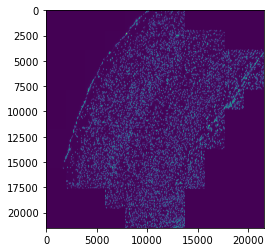

In [8]:
plt.imshow(raw_img)

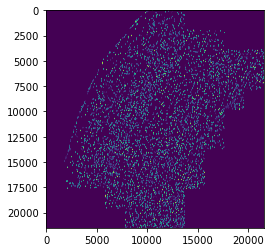

In [9]:
plt.imshow(luca_label)

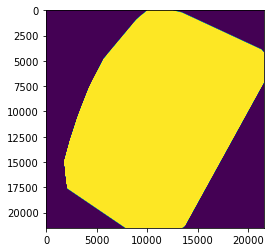

In [10]:
ROI_mask = skimage.morphology.convex_hull_image(luca_label > 0)
plt.imshow(ROI_mask)

In [12]:
print(luca_label.shape)
print(oleh_label.shape)
print(gt_label.shape)
print(raw_img.shape)

(21505, 21505)
(21505, 21505)
(21505, 21505)
(21505, 21505)


### Plot comparisons

In [29]:
def make_list_of_windows(ROI_mask: numpy.ndarray, n: int = 4, crop_size: int = 80):
    window = list()
    while len(window)<n:
        iw = numpy.random.randint(low=0, high=ROI_mask.shape[0]-crop_size, size=1, dtype=int).item()
        ih = numpy.random.randint(low=0, high=ROI_mask.shape[1]-crop_size, size=1, dtype=int).item()
        fraction = float(numpy.sum(ROI_mask[iw:iw+crop_size, ih:ih+crop_size]))/(iw*ih)
        if fraction<0.3 :
            continue
        else:
            window.append((iw,ih,iw+crop_size,ih+crop_size))
    return window

def plot_comparison(raw_img: numpy.ndarray, 
                    labels1: numpy.ndarray, 
                    labels2: Optional[numpy.ndarray] = None, 
                    labels3: Optional[numpy.ndarray] = None,
                    window: Optional[list] = None, 
                    figsize: tuple =(24,24)):
    if window is None:
        window = [[0,0,img1.shape[0],img1.shape[1]]]
    
    n = len(window)
    if n>1:
        fig, axs = plt.subplots(nrows=n, ncols=3, figsize=figsize)
    else:
        fig, axs = plt.subplots(ncols=3, figsize=figsize)
        
    for row,w in enumerate(window):
        img = raw_img[w[0]:w[2],w[1]:w[3]]
        l1 = labels1[w[0]:w[2],w[1]:w[3]]
        l2 = labels2[w[0]:w[2],w[1]:w[3]]
        l3 = labels3[w[0]:w[2],w[1]:w[3]]
        c1 = contours_from_labels(l1, contour_thickness=3)
        c2 = contours_from_labels(l2, contour_thickness=3)
        c3 = contours_from_labels(l3, contour_thickness=3)
        tmp1 = add_red_contours(img, c1)
        tmp2 = add_red_contours(img, c2)
        tmp3 = add_red_contours(img, c3)
        # print(tmp1.dtype, img.dtype)

        if n>1:
            axs[row,0].imshow(tmp1, aspect='equal')
            axs[row,1].imshow(tmp2, aspect='equal')
            axs[row,2].imshow(tmp3, aspect='equal')
        else:
            axs[0].imshow(tmp1, aspect='equal')
            axs[1].imshow(tmp2, aspect='equal')
            axs[2].imshow(tmp3, aspect='equal')

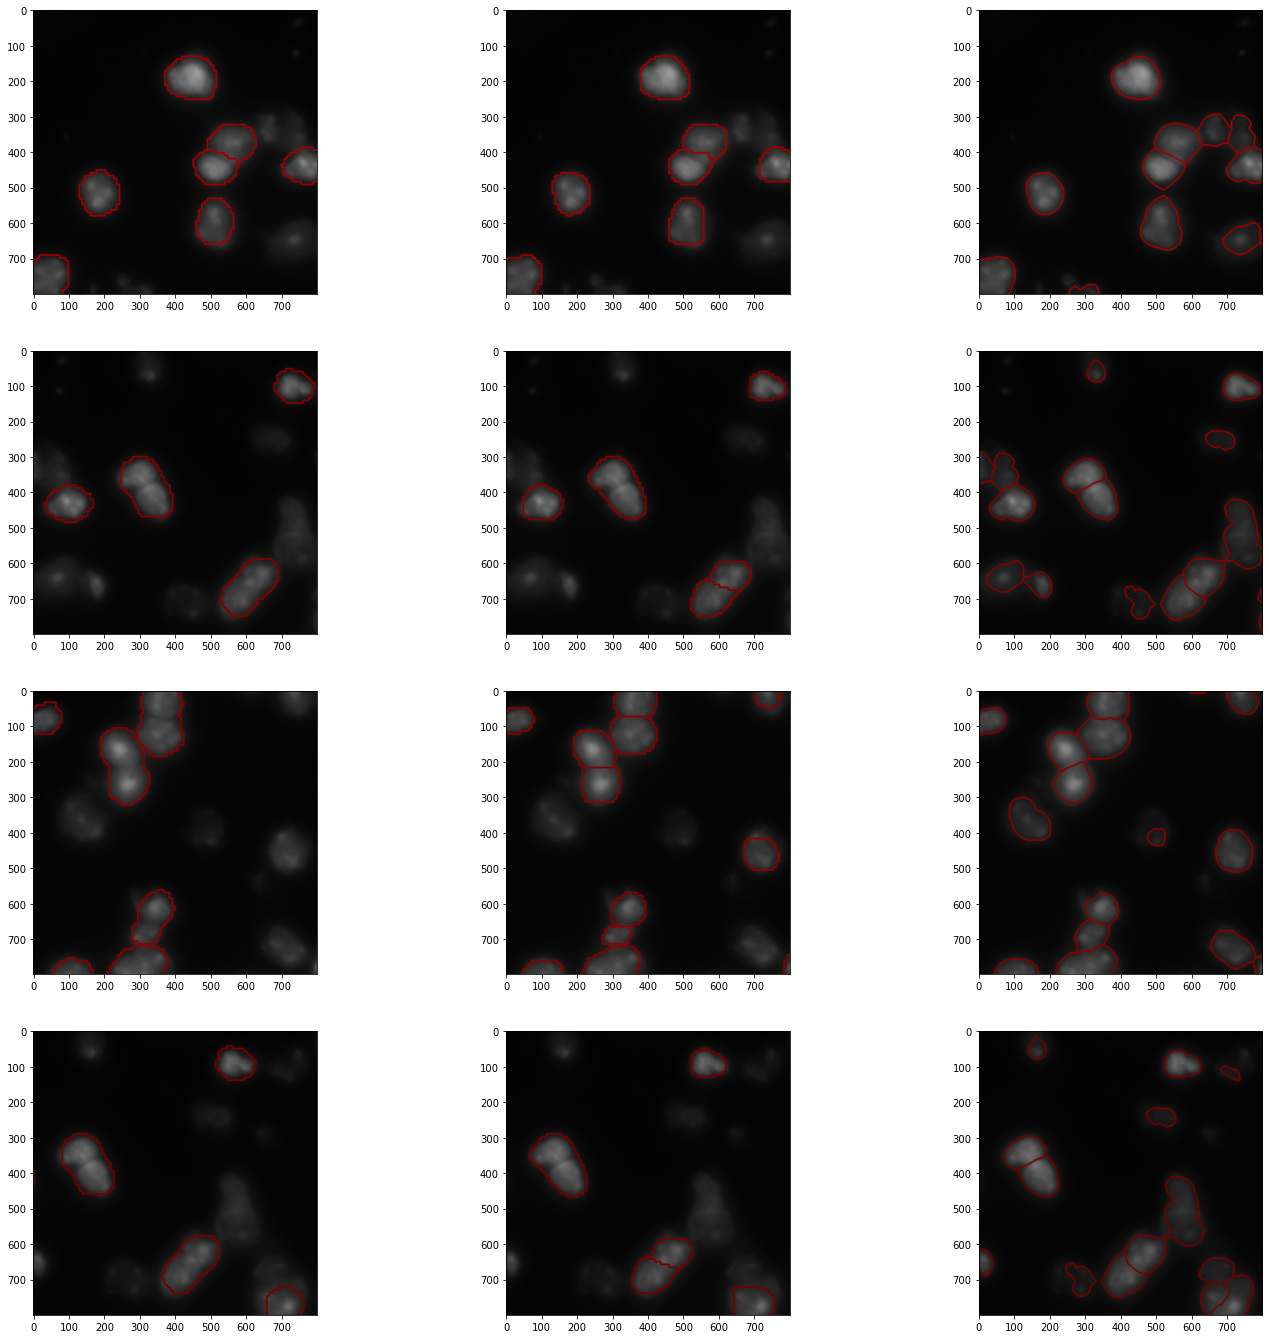

In [45]:
window = make_list_of_windows(ROI_mask, n=4, crop_size=800)
plot_comparison(raw_img, luca_label, luca_label_old, oleh_label, window=window, figsize=(24,24))